# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import xgboost as xgb
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from script.ddG2ee import get_ddG2ee
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
des=np.load('./data/des.npy')
ddg=np.load('./data/ddg.npy')
acid_index=np.load('./data/acid_index.npy')
sub_smi=np.load('./data/sub_smi.npy')
alk_smi=np.load('./data/alk_smi.npy')
acid_smi=np.load('./data/acid_smi.npy')

# Model Selection

In [3]:
models = [BaggingRegressor(n_jobs=60),
          tree.DecisionTreeRegressor(),ExtraTreesRegressor(n_jobs=60),GradientBoostingRegressor(),
          KNeighborsRegressor(),KernelRidge(),
          LinearSVR(),RandomForestRegressor(n_jobs=60),
          linear_model.Ridge(alpha=.5),SVR(), xgb.XGBRegressor(n_jobs=60)]#AdaBoostRegressor(ExtraTreesRegressor(n_jobs=60)),
model_names = ['BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge','SVR','XGB']#'Ada',
descs = [des]
desc_names = ['CD']

In [6]:
kfold = KFold(n_splits=10,shuffle=True)
performance_dict = {}
train_index=list(set(list(range(69))))
for desc,desc_name in zip(descs,desc_names): 
    desc=desc[train_index]
    ee_=ddg[train_index]
    for model,model_name in zip(models,model_names):
        all_r2 = []
        all_pearsr = []
        all_mae = []
        repeat_pred = []
        repeat_test = []
        for i in range(10):
            all_pred = []
            all_test = []
            for train_index_tep,test_index_tep in kfold.split(desc):
                train_x,test_x = desc[train_index_tep],desc[test_index_tep]
                train_y,test_y = ee_[train_index_tep],ee_[test_index_tep]
                model.fit(train_x,train_y)
                test_pred = model.predict(test_x)
                all_pred.append(test_pred)
                all_test.append(test_y)
            all_pred = np.concatenate(all_pred)
            all_test = np.concatenate(all_test)
            repeat_pred.append(all_pred)
            repeat_test.append(all_test)
            r2 = r2_score(all_test,all_pred)
            pearsr = pearsonr(all_test,all_pred)
            mae = mean_absolute_error(all_test,all_pred)
            all_r2.append(r2)
            all_pearsr.append(pearsr[0])
            all_mae.append(mae)
        performance_dict['%s-%s'%(model_name,desc_name)] = [np.mean(all_r2),np.mean(all_mae),np.mean(all_pearsr),
                                                            repeat_pred[np.argmax(all_r2)],repeat_test[np.argmax(all_r2)]]
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,np.mean(all_r2),np.mean(all_mae),np.mean(all_pearsr)))

Model:    BG, Descriptor:              CD: R2: 0.7061, MAE: 0.1949, Pearson R: 0.8431
Model:    DT, Descriptor:              CD: R2: 0.5646, MAE: 0.2354, Pearson R: 0.7852
Model:    ET, Descriptor:              CD: R2: 0.7270, MAE: 0.1793, Pearson R: 0.8558
Model:    GB, Descriptor:              CD: R2: 0.6934, MAE: 0.1991, Pearson R: 0.8393
Model:   KNR, Descriptor:              CD: R2: 0.6087, MAE: 0.2292, Pearson R: 0.7806
Model:   KRR, Descriptor:              CD: R2: 0.7077, MAE: 0.1955, Pearson R: 0.8420
Model:  LSVR, Descriptor:              CD: R2: 0.7061, MAE: 0.2033, Pearson R: 0.8498
Model:    RF, Descriptor:              CD: R2: 0.7343, MAE: 0.1836, Pearson R: 0.8582
Model: Ridge, Descriptor:              CD: R2: 0.7117, MAE: 0.1954, Pearson R: 0.8444
Model:   SVR, Descriptor:              CD: R2: 0.6804, MAE: 0.2144, Pearson R: 0.8313
Model:   XGB, Descriptor:              CD: R2: 0.6622, MAE: 0.2078, Pearson R: 0.8253


## Pearson R

<AxesSubplot:>

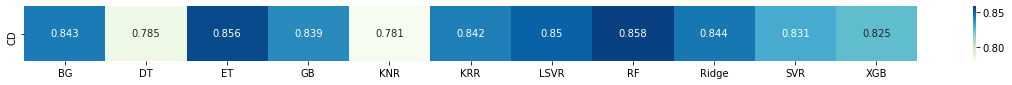

In [7]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][2]

fig = plt.figure(figsize=(20,1))
sns.heatmap(r2_map,annot=True,fmt='.3g',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu')

## MAE

<AxesSubplot:>

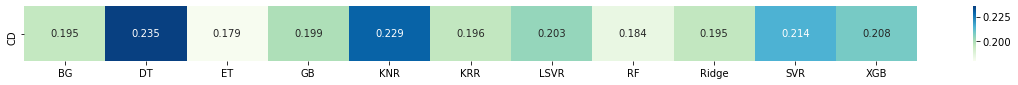

In [8]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][1]

fig = plt.figure(figsize=(20,1))
sns.heatmap(r2_map,annot=True,fmt='.3g',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu')

## Best Results

Text(0.1, 1.6, 'MAE: 0.175')

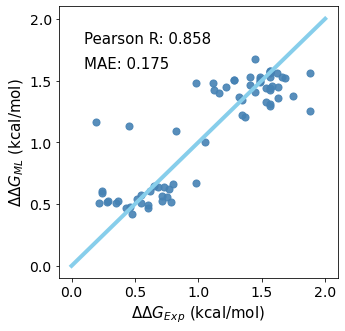

In [11]:
model = 'RF-CD'
train_y = performance_dict[model][4]
train_p = performance_dict[model][3]

fig = plt.figure(figsize=(5,5))
plt.xticks(np.arange(0, 2.1, step=0.5),fontsize=14)
plt.yticks(np.arange(0, 2.1, step=0.5),fontsize=14)
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=15)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=15)
plt.plot([0,2],[0,2],c='skyblue',linewidth=4)
plt.scatter(np.array(train_y),np.array(train_p),c='steelblue',s=50, alpha=0.9)
plt.text(0.1,1.8,'Pearson R: %.3f'%performance_dict[model][2],fontsize=15)
#plt.text(2,90,'$R^2$: %.3f'%(r2_score(np.array(train_y)*100,np.array(train_p)*100)),fontsize=15)
plt.text(0.1,1.6,'MAE: %.3f'%mean_absolute_error(np.array(train_y),np.array(train_p)),fontsize=15)

In [12]:
np.save('./data/direct_performance_dict.npy',performance_dict)

# Descriptor Selection

In [29]:
kfold = KFold(n_splits=10,shuffle=True)
sel_index=[40, 92, 57, 35, 18, 12, 52, 104, 45, 62, 101, 43, 20, 49, 22, 74, 15, 82, 100, 21, 44, 93, 37, 25, 102]
des_sel=des[:,sel_index]
train_index=list(set(list(range(0,69))))
des_k=des_sel[train_index]
ddg_k=ddg[train_index]

model=RandomForestRegressor(n_jobs=60)
for i in range(1):
    all_pred = []
    all_test = []
    for train_index_tep,test_index_tep in kfold.split(des_k):
        train_x,test_x = des_k[train_index_tep],des_k[test_index_tep]
        train_y,test_y = ddg_k[train_index_tep],ddg_k[test_index_tep]
        model.fit(train_x,train_y)
        test_pred = model.predict(test_x)
        all_pred.append(test_pred)
        all_test.append(test_y)
    all_pred = np.concatenate(all_pred)
    all_test = np.concatenate(all_test)

Text(0.1, 1.6, 'MAE: 0.187')

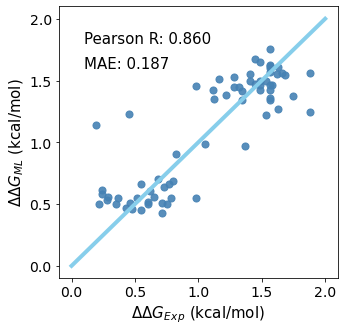

In [33]:
fig = plt.figure(figsize=(5,5))
plt.xticks(np.arange(0, 2.1, step=0.5),fontsize=14)
plt.yticks(np.arange(0, 2.1, step=0.5),fontsize=14)
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=15)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=15)
plt.plot([0,2],[0,2],c='skyblue',linewidth=4)
plt.scatter(np.array(all_test),np.array(all_pred),c='steelblue',s=50, alpha=0.9)
plt.text(0.1,1.8,'Pearson R: %.3f'%pearsonr(all_test,all_pred)[0],fontsize=15)
#plt.text(2,90,'$R^2$: %.3f'%(r2_score(np.array(train_y)*100,np.array(all_pred)*100)),fontsize=15)
plt.text(0.1,1.6,'MAE: %.3f'%mean_absolute_error(np.array(all_test),np.array(all_pred)),fontsize=15)

In [31]:
np.save('./data/69_all_pred.npy',all_pred)
np.save('./data/69_all_test.npy',all_test)

# Predict Enantioselectivity of 360 Acids

In [36]:
all_num=69+360
train_index=list(set(list(range(69))))
test_index=list(set(list(range(69,all_num))))
model = ExtraTreesRegressor(n_jobs=60)
train_x,test_x1 = des_sel[train_index],des_sel[test_index]
train_y= ddg[train_index]

all_pred_test=[]
pred_test13=[]
for i in range(20):
    model.fit(train_x,train_y)
    pred_test=model.predict(test_x1)
    all_pred_test.append(pred_test)
    #pred_test13.append(model.predict(val_x))
all_pred_test=np.mean(np.array(all_pred_test),axis=0)


In [37]:
saa_cat=np.concatenate((np.array(sub_smi[69:all_num]).reshape(-1,1),
                        np.array(alk_smi[69:all_num]).reshape(-1,1),
                        np.array(acid_smi[69:all_num]).reshape(-1,1)),axis=1)
result_455=pd.DataFrame(saa_cat,columns=['sub','alk','acids'],dtype=str)
result_455['ddg']=all_pred_test

t_ee=result_455['ddg'].to_list()
acid=np.array(result_455['acids'].to_list())
ee_rank=sorted(t_ee,reverse=True)
index=[]
for tem_ee in ee_rank:
    for tem_index,j in enumerate(t_ee):
        if tem_ee==j:
            index.append(tem_index)
acid_rank=acid[index]

# New Rank of Top3

In [39]:
top3_smi=['O=C(C1=CC=CO1)N2C(C(O)=O)N(C(C3=CC=CO3)=O)[C@@H](C4=CC=CC=C4)[C@@H]2C5=CC=CC=C5',
'O=C(C1=COC=C1)N2C(C(O)=O)N(C(C3=COC=C3)=O)[C@@H](C4=CC=CC=C4)[C@@H]2C5=CC=CC=C5',
'O=C(C1=CC=C(OC)C=C1)N2C(C(O)=O)N(C(C3=CC=C(OC)C=C3)=O)[C@@H](C4=CC=CC=C4)[C@@H]2C5=CC=CC=C5']

for i in top3_smi:
    for index,j in enumerate(acid_rank):
        if Chem.MolToSmiles(Chem.MolFromSmiles(i))==Chem.MolToSmiles(Chem.MolFromSmiles(j)):
            print(i,index,ee_rank[index],get_ddG2ee(np.array(ee_rank[index])))

O=C(C1=CC=CO1)N2C(C(O)=O)N(C(C3=CC=CO3)=O)[C@@H](C4=CC=CC=C4)[C@@H]2C5=CC=CC=C5 132 1.2851884289855744 0.7945296184395728
O=C(C1=COC=C1)N2C(C(O)=O)N(C(C3=COC=C3)=O)[C@@H](C4=CC=CC=C4)[C@@H]2C5=CC=CC=C5 77 1.3316462398285556 0.8085298292865927
O=C(C1=CC=C(OC)C=C1)N2C(C(O)=O)N(C(C3=CC=C(OC)C=C3)=O)[C@@H](C4=CC=CC=C4)[C@@H]2C5=CC=CC=C5 5 1.4884204507049246 0.8496664068595129
